In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import pickle

from game import *
from agents import *
from checkers import *

In [2]:
class MLP:
    """Implement a feed-forward neural network"""

    def __init__(self, architecture, random=None, weights=None):

        # Unpack model architecture
        self.params = {
            'dim_hidden': architecture['width'], # List of number of nodes per layer
            'dim_in': architecture['input_dim'],
            'dim_out': architecture['output_dim'],
            'activation_type': architecture['activation_fn_type'],
            'activation_params': architecture['activation_fn_params'],
        }
        self.activation = architecture['activation_fn']

        # Number of parameters (weights + biases) in input layer
        self.D_in = self.params['dim_in'] * self.params['dim_hidden'][0] + self.params['dim_hidden'][0]

        # Number of parameters (weights + biases) in hidden layers
        self.D_hidden = 0
        for i, h in enumerate(self.params['dim_hidden'][1:]):
            # Multiply previous layer width by current layer width plus the bias (current layer width)
            self.D_hidden += self.params['dim_hidden'][i] * h + h

        # Number of parameters (weights + biases) in output layer
        self.D_out = self.params['dim_hidden'][-1] * self.params['dim_out'] + self.params['dim_out']

        # Number of total parameters
        self.D = self.D_in + self.D_hidden + self.D_out

        # Set random state for reproducibility
        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        # Initiate model parameters (weights + biases)
        if weights is None:
            self.weights = self.random.normal(0, 0.01, size=(1, self.D))
        else:
            assert weights.shape == (1, self.D)
            self.weights = weights

        # To inspect model training later
        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x, return_features=False):
        """Forward pass given weights and input data.

        Returns:
            output (numpy.array): Model predictions of shape (n_mod, n_param, n_obs).
        """
        ''' Forward pass given weights and input '''
        H = self.params['dim_hidden']
        dim_in = self.params['dim_in']
        dim_out = self.params['dim_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == dim_in
            x = x.reshape((1, dim_in, -1))
        else:
            assert x.shape[1] == dim_in

        weights = weights.T # Shape: (n_obs, n_param)

        #input to first hidden layer
        W = weights[:H[0] * dim_in].T.reshape((-1, H[0], dim_in))
        b = weights[H[0] * dim_in:H[0] * dim_in + H[0]].T.reshape((-1, H[0], 1))
        input = self.activation(np.matmul(W, x) + b)
        index = H[0] * dim_in + H[0]

        assert input.shape[1] == H[0]

        #additional hidden layers
        for i in range(len(self.params['dim_hidden']) - 1):
            W = weights[index:index + H[i] * H[i+1]].T.reshape((-1, H[i+1], H[i]))
            index += H[i] * H[i+1]
            b = weights[index:index + H[i+1]].T.reshape((-1, H[i+1], 1))
            index += H[i+1]
            output = np.matmul(W, input) + b
            input = self.activation(output)

            assert input.shape[1] == H[i+1]

        # Return values from the last hidden layer if desired
        if return_features:
            return input # Shape: (n_mod, n_param, n_obs)

        #output layer
        W = weights[index:index + H[-1] * dim_out].T.reshape((-1, dim_out, H[-1]))
        b = weights[index + H[-1] * dim_out:].T.reshape((-1, dim_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['dim_out']

        return output


    def _make_objective(self, x_train, y_train, reg_param=0):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''

        def objective(W, t):
            squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
#             mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W) / W.size**0.5
            mean_error = np.mean(squared_error) + reg_param * (np.linalg.norm(W)**2) / W.size
            return mean_error

        return objective, grad(objective)


    def _fit(self, objective, gradient, params):

        self.objective, self.gradient = (objective, gradient)

        ### set up optimization
        step_size = params.get('step_size', 0.01)
        max_iteration = params.get('max_iteration', 5000)
        check_point = params.get('check_point', 100)
        weights_init = params.get('init', self.weights.reshape((1, -1)))
        mass = params.get('mass', None)
        optimizer = params.get('optimizer', 'adam')
        random_restarts = params.get('random_restarts', 5)

        # Define callback function
        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} loss {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))
        call_back = params.get('call_back', call_back)

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])

            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]


    def fit(self, x_train, y_train, params):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['dim_in']
        assert y_train.shape[0] == self.params['dim_out']

        # Make objective function for training
        reg_param = params.get('reg_param', 0) # No regularization by default
        objective, gradient = self._make_objective(x_train, y_train, reg_param)

        # Train model
        self._fit(objective, gradient, params)


In [3]:
class ReinforcementLearningAgent(Agent):

    def __init__(self, is_learning_agent=True, reward_function=checkers_reward):
        Agent.__init__(self, is_learning_agent)

        self.episodes_so_far = 0
        self.reward_function = reward_function


    @abstractmethod
    def get_action(self, state):
        """
        state: the current state from which to take action

        Returns: the action to perform
        """
        # TODO call do_action from this method
        pass


    @abstractmethod
    def update(self, state, action, next_state, reward):
        """
        performs update for the learning agent

        state: the state (s) in which action was taken
        action: the action (a) taken in the state (s)
        next_state: the next state (s'), in which agnet will perform next action, 
                    that resulted from state (s) and action (a)
        reward: reward obtained for taking action (a) in state (s) and going to next state (s')
        """
        pass

    def start_episode(self):
        # Accumulate rewards while training for each episode and show total rewards 
        # at the end of each episode i.e. when stop episode
        self.prev_state = None
        self.prev_action = None

        self.episode_rewards = 0.0


    def stop_episode(self):
        # print('reward this episode', self.episode_rewards)
        pass

    @abstractmethod
    def start_learning(self):
        pass


    @abstractmethod
    def stop_learning(self):
        pass


    @abstractmethod
    def observe_transition(self, state, action, next_state, reward, next_action=None):
        pass


    @abstractmethod
    def observation_function(self, state):
        pass


#     # TODO
#     def reward_function(self, state, action, next_state):
#         # make a reward function for the environment
#         return checkers_reward(state, action, next_state)


    def do_action(self, state, action):
        """
        called by get_action to update previous state and action
        """
        self.prev_state = state
        self.prev_action = action


class QLearningAgent(ReinforcementLearningAgent):

    def __init__(self, feature_func=checkers_features_augmented, feature_count=34, reward_function=checkers_reward, alpha=0.01, gamma=0.1, epsilon=0.5, is_learning_agent=True, weights=None):

        """
        alpha: learning rate
        gamma: discount factor
        epsilon: exploration constant
        is_learning_agent: whether to treat this agent as learning agent or not
        weights: default weights
        """

        ReinforcementLearningAgent.__init__(self, is_learning_agent=is_learning_agent, reward_function=reward_function)

        self.original_alpha = alpha
        self.original_epsilon = epsilon

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.feature_func = feature_func
        self.feature_count = feature_count

        if not is_learning_agent:
            self.epsilon = 0.0
            self.alpha = 0.0


        if weights is None:
            # initialize weights for the features
            self.weights = np.zeros(self.feature_count)
        else:
            if len(weights) != self.feature_count:
                raise Exception("Invalid weights " + weights)

            self.weights = np.array(weights, dtype=float)


    def start_learning(self):
        """
        called by environment to notify agent of starting new episode
        """

        self.alpha = self.original_alpha
        self.epsilon = self.original_epsilon

        self.is_learning_agent = True


    def stop_learning(self):
        """
        called by environment to notify agent about end of episode
        """
        self.alpha = 0.0
        self.epsilon = 0.0

        self.is_learning_agent = False


    def get_q_value(self, state, action, features):
        """
          Returns: Q(state,action)
        """
        q_value = np.dot(self.weights, features)
        return q_value


    def compute_value_from_q_values(self, state):
        """
          Returns: max_action Q(state, action) where the max is over legal actions.
                   If there are no legal actions, which is the case at the terminal state, 
                   return a value of 0.0.
        """
        actions = state.get_legal_actions()

        if not actions:
            return 0.0

        q_values = \
        [self.get_q_value(state, action, self.feature_func(state, action)) for action in actions]

        return max(q_values)


    def compute_action_from_q_values(self, state, actions):
        """
          Returns: the best action to take in a state. If there are no legal actions,
                   which is the case at the terminal state, return None.
        """
        if not actions:
            return None

        # if max_value < 0:
        #     return random.choice(actions)

        arg_max = np.argmax([self.get_q_value(state, action, self.feature_func(state, action)) 
            for action in actions])

        return actions[arg_max]


    def get_action(self, state):
        """
          Returns: the action to take in the current state.  With probability self.epsilon,
                   take a random action and take the best policy action otherwise.  If there are
                   no legal actions, which is the case at the terminal state, returns None.
        """

        # Pick Action
        legal_actions = state.get_legal_actions()
        action = None

        if not legal_actions:
            return None

        if flip_coin(self.epsilon):
            action = random.choice(legal_actions)
        else:
            action = self.compute_action_from_q_values(state, legal_actions)

        self.do_action(state, action)
        return action


    def update(self, state, action, next_state, reward):

        features = self.feature_func(state, action)

        expected = reward + self.gamma * self.compute_value_from_q_values(next_state)
        current = self.get_q_value(state, action, features)

        temporal_difference = expected - current

        for i in range(self.feature_count):
            self.weights[i] = self.weights[i] + self.alpha * (temporal_difference) * features[i]


    def getPolicy(self, state):
        return self.compute_action_from_q_values(state, state.get_legal_actions())


    def getValue(self, state):
        return self.compute_value_from_q_values(state)  


    def observe_transition(self, state, action, next_state, reward, next_action=None):
        """
        state: the state (s) in which action was taken
        action: the action (a) taken in the state (s)
        next_state: the next state (s'), in which agnet will perform next action, 
                    that resulted from state (s) and action (a)
        reward: reward obtained for taking action (a) in state (s) and going to next state (s')
        """
        self.episode_rewards += reward
        self.update(state, action, next_state, reward)


    def observation_function(self, state):
        if self.prev_state is not None:
            reward = self.reward_function(self.prev_state, self.prev_action, state)
            # print('reward is', reward)
            self.observe_transition(self.prev_state, self.prev_action, state, reward)

    def update_parameters(self, freq, num_games):
        if num_games % freq == 0:
            self.original_alpha /= 2.0
            self.original_epsilon /= 2.0

In [4]:
class QLearningAgent_MLP(ReinforcementLearningAgent):

    def __init__(self, architecture, feature_func=checkers_features_augmented, feature_count=34, reward_function=checkers_reward, alpha=0.01, gamma=0.1, epsilon=0.5, is_learning_agent=True, weights=None):

        """
        alpha: learning rate
        gamma: discount factor
        epsilon: exploration constant
        is_learning_agent: whether to treat this agent as learning agent or not
        weights: default weights
        """

        ReinforcementLearningAgent.__init__(self, is_learning_agent=is_learning_agent, reward_function=reward_function)

        self.original_alpha = alpha
        self.original_epsilon = epsilon

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.beta = alpha
        
        self.feature_func = feature_func
        self.feature_count = feature_count
        self.architecture = architecture
        self.architecture['input_dim'] = feature_count
        
        self.params = {
            'step_size':1e-3,
            'max_iteration':1,
            'random_restarts':1,
            'reg_param':100.}

        if not is_learning_agent:
            self.epsilon = 0.0
            self.alpha = 0.0


        if weights is None:
            # initialize weights for the features
            self.nn = MLP(architecture)
        else:
            self.nn = MLP(architecture, weights = weights)

        self.mu = np.zeros(self.feature_count)

    def start_learning(self):
        """
        called by environment to notify agent of starting new episode
        """

        self.alpha = self.original_alpha
        self.epsilon = self.original_epsilon

        self.is_learning_agent = True


    def stop_learning(self):
        """
        called by environment to notify agent about end of episode
        """
        self.alpha = 0.0
        self.epsilon = 0.0

        self.is_learning_agent = False


    def get_q_value(self, state, action):
        """
          Returns: Q(state,action)
        """
        features = np.array(self.feature_func(state, action)).reshape(-1,1)
        q_value = self.nn.forward(self.nn.weights, features).flatten()
#         print(q_value, q_value.shape)
        return q_value


    def grad_q_value(self, features):
        
        def q_value(w):
            return self.nn.forward(w,features)
        
        return grad(q_value)
    

    def compute_value_from_q_values(self, state):
        """
          Returns: max_action Q(state, action) where the max is over legal actions.
                   If there are no legal actions, which is the case at the terminal state, 
                   return a value of 0.0.
        """
        actions = state.get_legal_actions()

        if not actions:
            return 0.0

        q_values = \
        [self.get_q_value(state, action) for action in actions]

        return max(q_values)


    def compute_action_from_q_values(self, state, actions):
        """
          Returns: the best action to take in a state. If there are no legal actions,
                   which is the case at the terminal state, return None.
        """
        if not actions:
            return None

        # if max_value < 0:
        #     return random.choice(actions)

        arg_max = np.argmax([self.get_q_value(state, action) for action in actions])

        return actions[arg_max]


    def get_action(self, state):
        """
          Returns: the action to take in the current state.  With probability self.epsilon,
                   take a random action and take the best policy action otherwise.  If there are
                   no legal actions, which is the case at the terminal state, returns None.
        """

        # Pick Action
        legal_actions = state.get_legal_actions()
        action = None

        if not legal_actions:
            return None

        if flip_coin(self.epsilon):
#             print(legal_actions, len(legal_actions))
            action_idx = np.random.choice(len(legal_actions))
            action = legal_actions[action_idx]
        else:
            action = self.compute_action_from_q_values(state, legal_actions)

        self.do_action(state, action)
        return action


    def update(self, state, action, next_state, reward):

        features = np.array(self.feature_func(state, action)).reshape(-1,1)

        expected = reward + self.gamma * self.compute_value_from_q_values(next_state)
        current = self.get_q_value(state, action)
        
#         self.nn.fit(features, np.array([expected]), self.params)

        temporal_difference = expected - current
        this_grad = self.grad_q_value(features)(self.nn.weights).reshape(1,-1)
        this_grad[~np.isfinite(this_grad)] = 0.

        self.nn.weights = self.nn.weights + self.alpha * temporal_difference * this_grad


        # self.mu = self.mu + self.beta * ((temporal_difference) * features - self.mu)
        # self.nn.weights = self.nn.weights + self.alpha * (features - self.gamma * )


    def getPolicy(self, state):
        return self.compute_action_from_q_values(state, state.get_legal_actions())


    def getValue(self, state):
        return self.compute_value_from_q_values(state)  


    def observe_transition(self, state, action, next_state, reward, next_action=None):
        """
        state: the state (s) in which action was taken
        action: the action (a) taken in the state (s)
        next_state: the next state (s'), in which agnet will perform next action, 
                    that resulted from state (s) and action (a)
        reward: reward obtained for taking action (a) in state (s) and going to next state (s')
        """
        self.episode_rewards += reward
        self.update(state, action, next_state, reward)


    def observation_function(self, state):
        if self.prev_state is not None:
            reward = self.reward_function(self.prev_state, self.prev_action, state)
            # print('reward is', reward)
            self.observe_transition(self.prev_state, self.prev_action, state, reward)

    def update_parameters(self, freq, num_games):
        if num_games % freq == 0:
            self.original_alpha /= 2.0
            self.original_epsilon /= 2.0

In [5]:
activation_fn = lambda x: 1/(1+np.exp(-x))
# activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [128,64]
hidden_layers = len(width)
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

# n_features = 33+32
# feature_func = combined_features

n_features = 34
feature_func = checkers_features_augmented

# n_features = 12
# feature_func = checkers_features_simple

# n_features = 32
# feature_func = raw_board_features

# reward_function = checkers_reward
reward_function = raw_reward

max_moves = 500
# np.random.seed(12)
# initial_weights = np.random.normal(size=n_features)
# initial_weights = np.zeros((n_features,))
first_agent = QLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function, alpha=0., gamma=0.9, epsilon=0., is_learning_agent=False, weights=None)

ab1 = AlphaBetaAgent(1)
ab2 = AlphaBetaAgent(2)
ab3 = AlphaBetaAgent(3)
rand_agent = RandomAgent()

quiet = True

first_agent_turn = True
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, rand_agent, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: Rand agent, RL agent play first', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)

first_agent_turn = False
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, rand_agent, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: Rand agent, RL agent play second', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)


first_agent_turn = True
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, ab1, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: AB1, RL agent play first', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done,'moves =', num_moves)


first_agent_turn = False
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, ab1, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: AB1, RL agent play second', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)


    

Oppn: Rand agent, RL agent play first win = False draw = False moves = 126
Oppn: Rand agent, RL agent play second win = True draw = False moves = 96
Oppn: AB1, RL agent play first win = False draw = False moves = 66
Oppn: AB1, RL agent play second win = False draw = False moves = 59


In [6]:
n_train_games = 2000
n_decay = 10
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3

first_agent = QLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function, alpha=0.001, gamma=0.9, epsilon=0.5, is_learning_agent=True, weights=None)

second_agent_list = [ab1, ab2, ab3, rand_agent]
all_results = []
all_draws = []
all_oppn_idx = []
all_weights = []
all_rewards = []
all_num = []
test_results_rand = []
test_results_1 = []
test_results_2 = []
test_results_3 = []
test_draws_rand = []
test_draws_1 = []
test_draws_2 = []
test_draws_3 = []

for n in range(n_train_games):
    
    # change alpha and epsilon after n_decay games
    if n%n_decay == n_decay-1:
        first_agent.alpha = max([0.99*first_agent.alpha, 1e-4])
        first_agent.epsilon = max([0.99*first_agent.epsilon, 0.1])
        print(n, 'Fraction of wins = ', np.mean(all_results[-n_decay:]), 'Fraction of draws = ', np.mean(all_draws[-n_decay:]))
        print(n ,'alpha = ',first_agent.alpha, 'epsilon = ',first_agent.epsilon)
    
    if n%100 == 0: print(n)
    # train against randomly selected agent
    first_agent_turn = bool(np.random.binomial(1,0.5))
    
    second_agent_idx = np.random.choice(len(second_agent_list))  
    all_oppn_idx.append(second_agent_idx)
    second_agent = second_agent_list[second_agent_idx]
#     second_agent = ab3
    
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet)    
    
    # random start
    for _ in range(np.random.choice(max_random_start_depth_train)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)
        
    num_moves, game_state = game.run()
    
    all_num.append(num_moves)
    all_rewards.append(first_agent.episode_rewards)
    all_results.append(game_state.is_first_agent_win())
    all_draws.append((game_state.max_moves_done))
#     all_weights.append(first_agent.nn.weights.copy())
        
    if n%test_frequency == 0:
#         print(n)
        
        all_weights.append(first_agent.nn.weights.copy())
        
        this_test_results_rand = []
        this_test_results_1 = []
        this_test_results_2 = []
        this_test_results_3 = []
        
        this_test_draws_rand = []
        this_test_draws_1 = []
        this_test_draws_2 = []
        this_test_draws_3 = []
        
        for n in range(n_games_test):
            test_agent = QLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function, alpha=0.0, gamma=0.7, epsilon=0., is_learning_agent=True, weights=all_weights[-1])

            # play against ab1
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)
            
            # random start
            random_start_spots = game.game_state.board.spots
            for _ in range(np.random.choice(max_random_start_depth_test)*2):
                possible_moves = game.game_state.board.get_possible_next_moves()
                next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                game.game_state.board.make_move(next_move, switch_player_turn=True)
                random_start_spots = game.game_state.board.spots
        
            num_moves, game_state = game.run()
            this_test_results_1.append(game_state.is_first_agent_win())
            this_test_draws_1.append(game_state.max_moves_done)
            
            # play against ab2
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_2.append(game_state.is_first_agent_win())
            this_test_draws_2.append(game_state.max_moves_done)
            
            # play against ab3
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_3.append(game_state.is_first_agent_win())
            this_test_draws_3.append(game_state.max_moves_done)
            
            # play against random agent
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_rand.append(game_state.is_first_agent_win())
            this_test_draws_rand.append(game_state.max_moves_done)
            
        test_results_1.append(np.mean(np.array(this_test_results_1)))
        test_results_2.append(np.mean(np.array(this_test_results_2)))
        test_results_3.append(np.mean(np.array(this_test_results_3)))
        test_results_rand.append(np.mean(np.array(this_test_results_rand)))
        
        test_draws_1.append(np.mean(np.array(this_test_draws_1)))
        test_draws_2.append(np.mean(np.array(this_test_draws_2)))
        test_draws_3.append(np.mean(np.array(this_test_draws_3)))
        test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))
        
        print('wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
        print('draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1])    

0
wins =  0.8 0.0 0.0 1.0
draws =  0.2 0.8 0.4 0.0
9 Fraction of wins =  0.2222222222222222 Fraction of draws =  0.0
9 alpha =  0.00099 epsilon =  0.495
wins =  0.4 0.0 0.0 0.9
draws =  0.5 0.0 0.0 0.0
19 Fraction of wins =  0.3 Fraction of draws =  0.1
19 alpha =  0.0009801 epsilon =  0.49005
wins =  0.5 0.0 0.1 1.0
draws =  0.4 0.4 0.2 0.0
29 Fraction of wins =  0.2 Fraction of draws =  0.1
29 alpha =  0.000970299 epsilon =  0.48514949999999996
wins =  0.6 0.0 0.0 1.0
draws =  0.2 0.3 0.3 0.0
39 Fraction of wins =  0.4 Fraction of draws =  0.0
39 alpha =  0.0009605960099999999 epsilon =  0.480298005
wins =  0.7 0.0 0.0 1.0
draws =  0.1 0.5 0.2 0.0
49 Fraction of wins =  0.2 Fraction of draws =  0.0
49 alpha =  0.0009509900498999999 epsilon =  0.47549502494999996
wins =  0.6 0.1 0.0 0.7
draws =  0.4 0.3 0.0 0.0
59 Fraction of wins =  0.1 Fraction of draws =  0.1
59 alpha =  0.0009414801494009999 epsilon =  0.47074007470049994
wins =  0.0 0.0 0.0 0.9
draws =  0.5 0.0 0.1 0.0
69 Fractio

/Users/shihyitseng/anaconda3/envs/am207/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


wins =  0.7 0.1 0.1 0.9
draws =  0.3 0.6 0.5 0.1
99 Fraction of wins =  0.3 Fraction of draws =  0.0
99 alpha =  0.0009043820750088043 epsilon =  0.45219103750440215
100
wins =  0.6 0.0 0.0 1.0
draws =  0.3 0.8 0.4 0.0
109 Fraction of wins =  0.2 Fraction of draws =  0.1
109 alpha =  0.0008953382542587163 epsilon =  0.44766912712935814
wins =  0.5 0.0 0.1 1.0
draws =  0.5 0.5 0.1 0.0
119 Fraction of wins =  0.4 Fraction of draws =  0.0
119 alpha =  0.0008863848717161291 epsilon =  0.44319243585806456
wins =  0.3 0.4 0.0 1.0
draws =  0.2 0.5 0.6 0.0
129 Fraction of wins =  0.5 Fraction of draws =  0.0
129 alpha =  0.0008775210229989678 epsilon =  0.4387605114994839
wins =  0.5 0.1 0.0 1.0
draws =  0.4 0.3 0.4 0.0
139 Fraction of wins =  0.2 Fraction of draws =  0.0
139 alpha =  0.0008687458127689781 epsilon =  0.43437290638448905
wins =  0.9 0.1 0.0 1.0
draws =  0.1 0.8 0.3 0.0
149 Fraction of wins =  0.3 Fraction of draws =  0.1
149 alpha =  0.0008600583546412883 epsilon =  0.430029177

/Users/shihyitseng/anaconda3/envs/am207/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/shihyitseng/anaconda3/envs/am207/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


wins =  0.6 0.0 0.0 1.0
draws =  0.4 0.3 0.2 0.0
479 Fraction of wins =  0.4 Fraction of draws =  0.1
479 alpha =  0.0006172901409422877 epsilon =  0.308645070471144
wins =  0.6 0.0 0.0 1.0
draws =  0.4 0.6 0.3 0.0
489 Fraction of wins =  0.5 Fraction of draws =  0.0
489 alpha =  0.0006111172395328649 epsilon =  0.30555861976643256
wins =  0.7 0.0 0.0 1.0
draws =  0.3 0.3 0.6 0.0
499 Fraction of wins =  0.3 Fraction of draws =  0.0
499 alpha =  0.0006050060671375363 epsilon =  0.30250303356876823
500
wins =  0.8 0.1 0.1 1.0
draws =  0.1 0.8 0.3 0.0
509 Fraction of wins =  0.7 Fraction of draws =  0.0
509 alpha =  0.0005989560064661609 epsilon =  0.29947800323308055
wins =  0.6 0.0 0.0 1.0
draws =  0.3 0.3 0.2 0.0
519 Fraction of wins =  0.4 Fraction of draws =  0.0
519 alpha =  0.0005929664464014993 epsilon =  0.2964832232007497
wins =  0.8 0.0 0.0 1.0
draws =  0.1 0.7 0.2 0.0
529 Fraction of wins =  0.5 Fraction of draws =  0.0
529 alpha =  0.0005870367819374844 epsilon =  0.293518390

wins =  0.8 0.0 0.0 1.0
draws =  0.2 0.6 0.0 0.0
969 Fraction of wins =  0.7 Fraction of draws =  0.1
969 alpha =  0.00037723664692350416 epsilon =  0.18861832346175217
wins =  0.7 0.0 0.1 1.0
draws =  0.3 0.4 0.4 0.0
979 Fraction of wins =  0.5 Fraction of draws =  0.2
979 alpha =  0.00037346428045426913 epsilon =  0.18673214022713464
wins =  0.7 0.3 0.0 1.0
draws =  0.2 0.1 0.6 0.0
989 Fraction of wins =  0.2 Fraction of draws =  0.0
989 alpha =  0.00036972963764972643 epsilon =  0.18486481882486328
wins =  0.7 0.0 0.1 1.0
draws =  0.1 0.9 0.6 0.0
999 Fraction of wins =  0.5 Fraction of draws =  0.2
999 alpha =  0.00036603234127322915 epsilon =  0.18301617063661463
1000
wins =  0.9 0.3 0.1 1.0
draws =  0.1 0.5 0.5 0.0
1009 Fraction of wins =  0.4 Fraction of draws =  0.0
1009 alpha =  0.00036237201786049685 epsilon =  0.18118600893024847
wins =  0.9 0.3 0.0 1.0
draws =  0.1 0.0 0.2 0.0
1019 Fraction of wins =  0.6 Fraction of draws =  0.0
1019 alpha =  0.0003587482976818919 epsilon =

1449 Fraction of wins =  0.3 Fraction of draws =  0.3
1449 alpha =  0.00023286446294800602 epsilon =  0.116432231474003
wins =  0.6 0.0 0.0 1.0
draws =  0.4 0.7 0.1 0.0
1459 Fraction of wins =  0.6 Fraction of draws =  0.3
1459 alpha =  0.00023053581831852595 epsilon =  0.11526790915926297
wins =  0.3 0.0 0.0 1.0
draws =  0.5 0.7 0.3 0.0
1469 Fraction of wins =  0.4 Fraction of draws =  0.0
1469 alpha =  0.0002282304601353407 epsilon =  0.11411523006767034
wins =  0.6 0.0 0.0 1.0
draws =  0.3 0.8 0.2 0.0
1479 Fraction of wins =  0.2 Fraction of draws =  0.2
1479 alpha =  0.00022594815553398729 epsilon =  0.11297407776699364
wins =  0.6 0.0 0.0 1.0
draws =  0.3 0.5 0.0 0.0
1489 Fraction of wins =  0.4 Fraction of draws =  0.0
1489 alpha =  0.0002236886739786474 epsilon =  0.11184433698932371
wins =  0.6 0.0 0.0 0.9
draws =  0.3 0.9 0.4 0.0
1499 Fraction of wins =  0.6 Fraction of draws =  0.1
1499 alpha =  0.00022145178723886094 epsilon =  0.11072589361943047
1500
wins =  0.6 0.0 0.0 0.

wins =  0.5 0.0 0.0 1.0
draws =  0.5 0.5 0.3 0.0
1969 Fraction of wins =  0.4 Fraction of draws =  0.3
1969 alpha =  0.00013808081308747282 epsilon =  0.1
wins =  1.0 0.0 0.0 1.0
draws =  0.0 0.4 0.4 0.0
1979 Fraction of wins =  0.3 Fraction of draws =  0.0
1979 alpha =  0.00013670000495659808 epsilon =  0.1
wins =  0.4 0.0 0.0 1.0
draws =  0.4 0.6 0.2 0.0
1989 Fraction of wins =  0.4 Fraction of draws =  0.1
1989 alpha =  0.0001353330049070321 epsilon =  0.1
wins =  0.8 0.2 0.0 1.0
draws =  0.0 0.5 0.4 0.0
1999 Fraction of wins =  0.3 Fraction of draws =  0.0
1999 alpha =  0.00013397967485796178 epsilon =  0.1


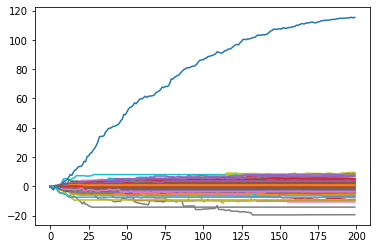

In [7]:
all_weights_array = np.stack(all_weights)
np.squeeze(all_weights_array).shape
plt.plot(np.squeeze(all_weights_array)[:,::20]);

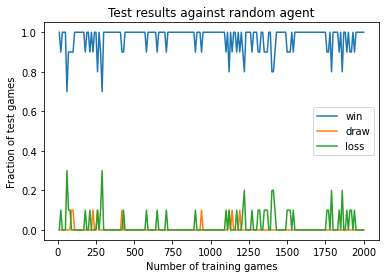

In [8]:
loss_rand = 1-np.array(test_results_rand)-np.array(test_draws_rand)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_rand,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_rand,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_rand,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against random agent');

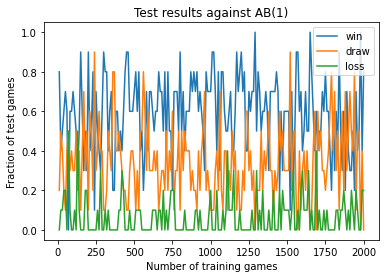

In [9]:
loss_1 = 1-np.array(test_results_1)-np.array(test_draws_1)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_1,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_1,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_1,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(1)');

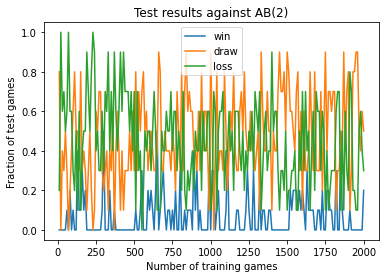

In [10]:
loss_2 = 1-np.array(test_results_2)-np.array(test_draws_2)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_2,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_2,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_2,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(2)');

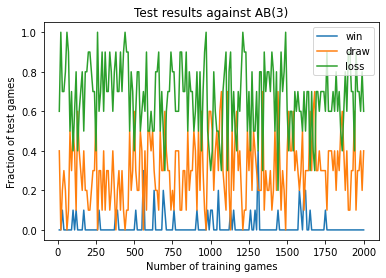

In [11]:
loss_3 = 1-np.array(test_results_3)-np.array(test_draws_3)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_3,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_3,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_3,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(3)');

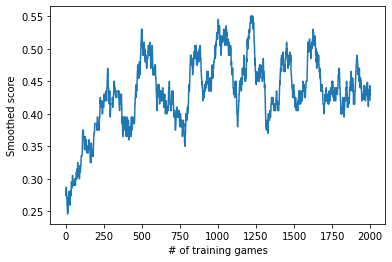

In [13]:
w = 100
calib = np.convolve(np.ones(n_train_games), np.ones(w), 'same')
all_score = 1*np.array(all_results) + 0.5*np.array(all_draws)
mean_smooth_score = np.convolve(all_score, np.ones(w), 'same') / calib
plt.plot(mean_smooth_score)
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

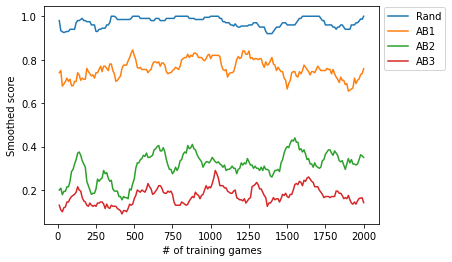

In [14]:
w = 10
calib = np.convolve(np.ones(len(test_results_rand)), np.ones(w), 'same')
all_score_rand = 1*np.array(test_results_rand) + 0.5*np.array(test_draws_rand)
all_score_1 = 1*np.array(test_results_1) + 0.5*np.array(test_draws_1)
all_score_2 = 1*np.array(test_results_2) + 0.5*np.array(test_draws_2)
all_score_3 = 1*np.array(test_results_3) + 0.5*np.array(test_draws_3)
mean_smooth_score_rand = np.convolve(all_score_rand, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_rand, label='Rand')
mean_smooth_score_1 = np.convolve(all_score_1, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_1, label='AB1')
mean_smooth_score_2 = np.convolve(all_score_2, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_2,label='AB2')
mean_smooth_score_3 = np.convolve(all_score_3, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_3,label='AB3')
plt.legend(bbox_to_anchor=(1,1.02))
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

In [15]:
data = {'all_results':all_results,
        'all_draws':all_draws,
        'all_oppn_idx':all_oppn_idx,
        'all_weights':all_weights,
        'all_num':all_num,
        'all_rewards':all_rewards,
        'test_results_rand':test_results_rand,
        'test_results_1':test_results_1,
        'test_results_2':test_results_2,
        'test_results_3':test_results_3,
        'test_draws_rand':test_draws_rand,
        'test_draws_1':test_draws_1,
        'test_draws_2':test_draws_2,
        'test_draws_3':test_draws_3}
with open(r"Qlearning_with_MLP_33_features_raw_reward_mix_oppn.pkl", "wb") as f:
    pickle.dump(data, f)